In [2]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.3 MB/s eta 0:00:00


Il y a différentes manières d'optimiser les hyperparamètres, nous utiliserons ici [`Optuna`](https://optuna.org/)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("whitegrid")

In [4]:
# On plit le jeu de données en enlevant les métadonnées
train_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target
target_names = train_data.target_names

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {len(target_names)}")

Training samples: 11314
Test samples: 7532
Number of classes: 20


In [5]:
def create_pipeline(params: dict) -> Pipeline:
    """Create a TF-IDF + Logistic Regression pipeline with given parameters."""
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=params['max_features'],
            ngram_range=(1, params['ngram_max']),
            min_df=params['min_df'],
            max_df=params['max_df'],
            sublinear_tf=params.get('sublinear_tf', True),
            stop_words='english'
        )),
        ('clf', LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver='saga',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        ))
    ])

def objective(trial: optuna.Trial) -> float:
    """Optuna objective function for hyperparameter optimization."""
    params = {
        # TF-IDF hyperparameters
        'max_features': trial.suggest_int('max_features', 5000, 30000, step=2500),
        'ngram_max': trial.suggest_int('ngram_max', 1, 2),
        'min_df': trial.suggest_int('min_df', 2, 10),
        'max_df': trial.suggest_float('max_df', 0.7, 0.95),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
        # Logistic Regression hyperparameters
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
    }

    pipeline = create_pipeline(params)
    pipeline.fit(X_train, y_train)

    return accuracy_score(y_test, pipeline.predict(X_test))

In [6]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

# Display results
print(f"Best accuracy: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best accuracy: 0.6867
Best hyperparameters:
  max_features: 27500
  ngram_max: 2
  min_df: 6
  max_df: 0.7158518249890268
  sublinear_tf: True
  C: 3.5730595665181397
  penalty: l2


In [7]:
# Build final model with optimized parameters
best_params = study.best_params
final_pipeline = create_pipeline(best_params)
final_pipeline.fit(X_train, y_train)

# Generate predictions
y_pred = final_pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Final model accuracy: {final_accuracy:.4f}")

Final model accuracy: 0.6867


In [8]:
# Display detailed classification report
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

CLASSIFICATION REPORT
                          precision    recall  f1-score   support

             alt.atheism      0.495     0.464     0.479       319
           comp.graphics      0.641     0.715     0.676       389
 comp.os.ms-windows.misc      0.626     0.619     0.622       394
comp.sys.ibm.pc.hardware      0.652     0.640     0.646       392
   comp.sys.mac.hardware      0.730     0.688     0.709       385
          comp.windows.x      0.844     0.696     0.763       395
            misc.forsale      0.772     0.792     0.782       390
               rec.autos      0.713     0.710     0.711       396
         rec.motorcycles      0.745     0.741     0.743       398
      rec.sport.baseball      0.530     0.856     0.654       397
        rec.sport.hockey      0.900     0.855     0.877       399
               sci.crypt      0.864     0.674     0.757       396
         sci.electronics      0.596     0.590     0.593       393
                 sci.med      0.766     0.760     0.7

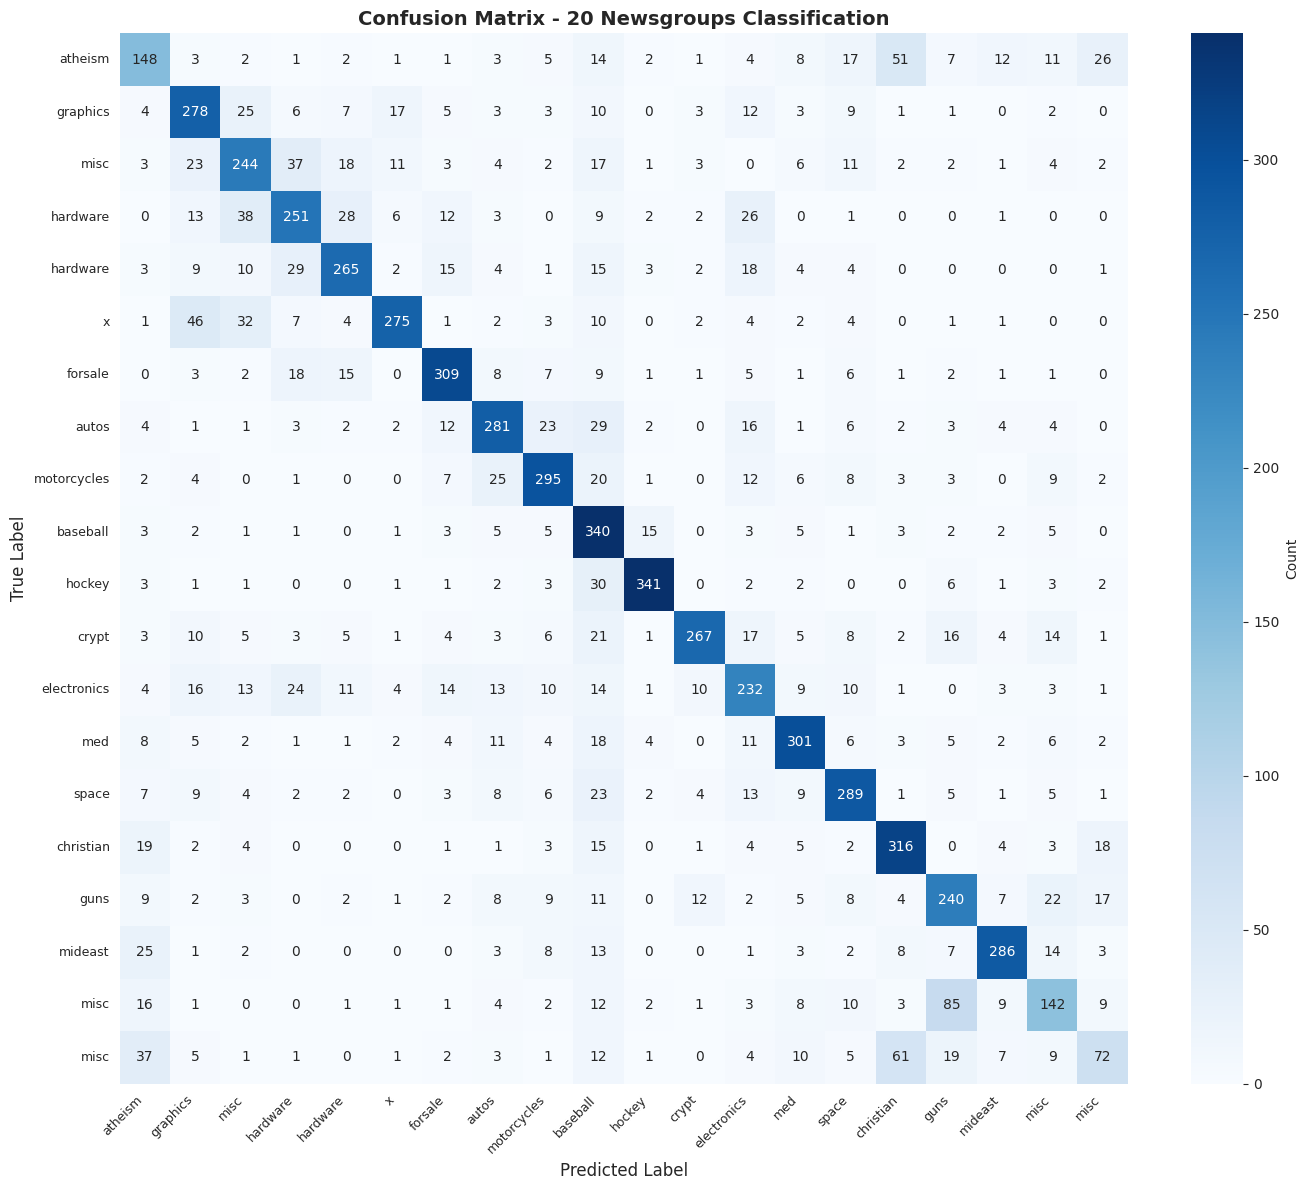

In [9]:
def plot_confusion_matrix(y_true, y_pred, labels, figsize=(14, 12)):
    """Plot a formatted confusion matrix with readable labels."""
    cm = confusion_matrix(y_true, y_pred)

    # Shorten labels for readability
    short_labels = [name.split('.')[-1] if '.' in name else name for name in labels]

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=short_labels, yticklabels=short_labels,
        cbar_kws={'label': 'Count'}, ax=ax
    )

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Confusion Matrix - 20 Newsgroups Classification', fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_test, y_pred, target_names)